In [1]:
import simpy
import random
import seaborn as sns
import pandas as pd
from common import tiempo_aleatorio_operador, aleatorio_exponencial
from common import nuevo_cliente, final_cliente

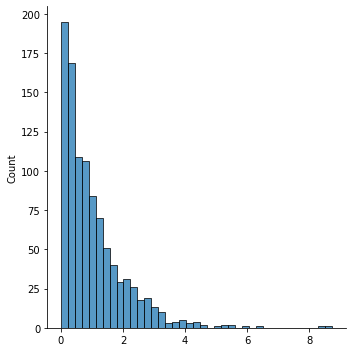

In [2]:
tiempos_clientes = []
for i in range(0,1000):
    t = aleatorio_exponencial(1)
    tiempos_clientes.append(t)
    
ax = sns.displot(tiempos_clientes)

## Declaracion de Objetos

### Objeto Operador

In [3]:
class Operador(object):
    def __init__(self, nombre, tiempo_prob):
        self.nombre = nombre
        self.tiempo_prob = tiempo_prob
        
    

### Objeto Evento

In [4]:
class Evento(object):
    def __init__(self, tipo, estado):
        self.tipo = tipo
        self.estado = estado
        

### Objeto Estado

In [5]:
class Estado(object):
    def __init__(self, tiempo, estado_operador, cola, tiempo_atencion=0):
        self.tiempo = tiempo
        self.estado_operador = estado_operador
        self.cola = cola
        self.tiempo_atencion = tiempo_atencion

# Operador 2

In [6]:
dict_probabilidades = {
    (0,0.3):2,
    (0.3,0.5):2.5,
    (0.5,0.75):3,
    (0.75,1):4
}

operador_1 = Operador('operador_b', dict_probabilidades)

In [7]:
tiempos_op1 = []
for i in range(0,1000):
    t = tiempo_aleatorio_operador(operador_1.tiempo_prob)
    tiempos_op1.append(t)

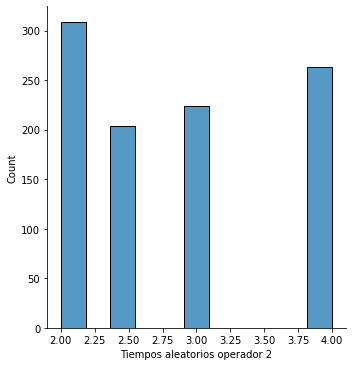

In [8]:
ax = sns.displot(tiempos_op1)
ax.set(xlabel="Tiempos aleatorios operador 2")

## Eventos

Tipos de evento:
- inicio
- nuevo_cliente
- final_cliente

# Simulacion

In [9]:
lista_eventos = []
lista_eventos_futuros = []

### Evento Inicial

In [10]:
# Tiempo = 0
# Estado operador = 0
# Cola = 0
estado_inicial = Estado(0, 0,0)

evento_inicial = Evento('inicio', estado_inicial)

In [11]:
lista_eventos_futuros.append(evento_inicial)

### Agregando Clientes

In [12]:
tiempo_clientes = 0
TOTAL_CLIENTES = 100

for i in range(TOTAL_CLIENTES):
    tiempo_clientes += aleatorio_exponencial(1)
    evento = Evento('nuevo_cliente', Estado(tiempo_clientes, 0,0))
    lista_eventos_futuros.append(evento)
    

In [13]:
estado_actual = Estado(0,0,0)
cliente_actual = 0

while (len(lista_eventos_futuros) > 0):
    
    #Obtenemos el siguiente evento futuro
    evento_actual = lista_eventos_futuros.pop(0)
    

    if evento_actual.tipo == 'nuevo_cliente':
        lista_eventos_futuros, estado_actual = nuevo_cliente(
            estado_actual,
            operador_1.tiempo_prob,
            evento_actual,
            lista_eventos_futuros
        )
       
     
    if evento_actual.tipo == 'final_cliente':
        lista_eventos_futuros, estado_actual = final_cliente(
            estado_actual,
            operador_1.tiempo_prob,
            evento_actual,
            lista_eventos_futuros
        )
        
        cliente_actual += 1
    
    
    nuevo_estado = Estado(
        estado_actual.tiempo,
        estado_actual.estado_operador,
        estado_actual.cola,
        evento_actual.estado.tiempo_atencion
    )
    
    nuevo_evento = Evento(evento_actual.tipo, nuevo_estado)
    lista_eventos.append(nuevo_evento)
    

## Resultados

### Objeto cliente

In [14]:
class Cliente(object):
    def __init__(self, id_cliente, tiempo_llegada, tiempo_salida, cola, tiempo_atencion):
        self.id_cliente = id_cliente
        self.tiempo_llegada = tiempo_llegada
        self.tiempo_salida = tiempo_salida
        self.cola = cola
        self.tiempo_atencion = tiempo_atencion
        

In [15]:
lista_clientes = []

In [16]:
id_cliente = 1
current_client = 0

for evento in lista_eventos:

    if evento.tipo == 'nuevo_cliente':
        cliente_nuevo = Cliente(id_cliente, evento.estado.tiempo, 0, evento.estado.cola, 0)
        id_cliente += 1
        lista_clientes.append(cliente_nuevo)
            
    if evento.tipo == 'final_cliente':
        lista_clientes[current_client].tiempo_atencion = evento.estado.tiempo_atencion
        lista_clientes[current_client].tiempo_salida = evento.estado.tiempo
        current_client +=1

In [17]:
clientes_dict = {
    'cliente': [],
    'tiempo_llegada': [],
    'tiempo_salida': [],
    'cola': [],
    'tiempo_atencion': [],
    'tiempo_cola' : []
}

In [18]:
for cliente in lista_clientes:
    # print(f"===== Cliente {cliente.id_cliente}")
    # print(f"Llegada {cliente.id_cliente}")
    # print(f"tiempo_llegada: {cliente.tiempo_llegada}")
    # print(f"tiempo_salida: {cliente.tiempo_salida}")
    # print(f"cola: {cliente.cola}")
    # print(f"tiempo_atencion: {cliente.tiempo_atencion}")
    
    clientes_dict['cliente'].append(f"Cliente {cliente.id_cliente}")
    clientes_dict['tiempo_llegada'].append(cliente.tiempo_llegada)
    clientes_dict['tiempo_salida'].append(cliente.tiempo_salida)
    clientes_dict['cola'].append(cliente.cola)
    clientes_dict['tiempo_atencion'].append(cliente.tiempo_atencion)
    
    tiempo_cola = 0
    if cliente.cola > 0:
        tiempo_cola = cliente.tiempo_salida - cliente.tiempo_atencion - cliente.tiempo_llegada
    
    clientes_dict['tiempo_cola'].append(tiempo_cola)

In [19]:
df_clientes = pd.DataFrame(clientes_dict)

In [20]:
df_clientes['tiempo_sistema'] = df_clientes.tiempo_salida - df_clientes.tiempo_llegada

In [21]:
df_clientes

,cliente,tiempo_llegada,tiempo_salida,cola,tiempo_atencion,tiempo_cola,tiempo_sistema
0,Cliente 1,0.175431,3.175431,0,3.0,0.000000,3.000000
1,Cliente 2,0.297140,5.675431,1,2.5,2.878290,5.378290
2,Cliente 3,1.017520,7.675431,2,2.0,4.657911,6.657911
3,Cliente 4,1.556141,9.675431,3,2.0,6.119290,8.119290
4,Cliente 5,3.121164,11.675431,4,2.0,6.554267,8.554267
...,...,...,...,...,...,...,...
95,Cliente 96,81.306117,273.675431,65,4.0,188.369314,192.369314
96,Cliente 97,81.545978,277.675431,66,4.0,192.129453,196.129453
97,Cliente 98,82.264312,280.675431,66,3.0,195.411119,198.411119
98,Cliente 99,83.213044,284.675431,67,4.0,197.462387,201.462387


# Estadisticas

In [22]:
clientes_cola = df_clientes[df_clientes.cola >0]

## Tiempo medio en Cola 

In [23]:
clientes_cola.tiempo_cola.mean()

95.66112413949791

/home/erick/anaconda3/envs/geometria_diff/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='tiempo_cola', ylabel='Density'>

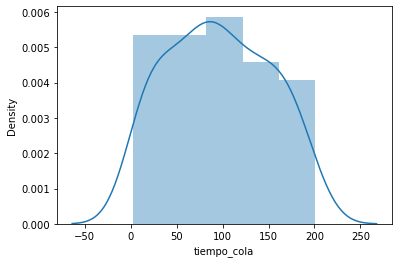

In [24]:
sns.distplot(clientes_cola.tiempo_cola)

## Longitud promedio de Cola

In [25]:
clientes_cola.cola.mean()

34.03030303030303

## Tiempo medio en el sistema

In [26]:
df_clientes.tiempo_sistema.mean()

97.57951289810293

/home/erick/anaconda3/envs/geometria_diff/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='tiempo_sistema', ylabel='Density'>

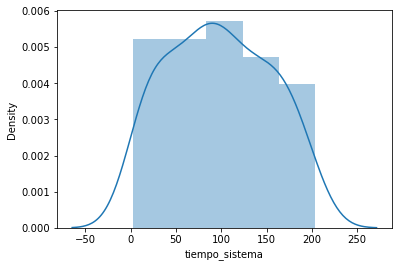

In [27]:
sns.distplot(df_clientes.tiempo_sistema)

## Porcentaje Ocupacion

```
for evento in lista_eventos:
    print(f"=== Evento: {evento.tipo} ===")
    print(f"Cola: {evento.estado.cola}")
    print(f"Estado Operador: {evento.estado.estado_operador}")
    print(f">> Tiempo: {evento.estado.tiempo}")
    
    if evento.tipo == 'final_cliente':
        print(f">> Tiempo Atencion: {evento.estado.tiempo_atencion}")
            
    print()
```